In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from statsmodels.tsa.arima.model import ARIMA
from cycler import cycler

%matplotlib inline

# Set color cycle for all plots
plt.rcParams["axes.prop_cycle"] = cycler(
    color=[plt.get_cmap("Set2")(i) for i in range(9)]
)

import warnings
warnings.simplefilter('ignore', FutureWarning)

In [29]:
# Set the file path here, and "Run All"
datasets_file_path = "../datasets/df_sample_5000.csv"

df_tmp = pd.read_csv(datasets_file_path)
customers = df_tmp["customer_unique_id"]

In [30]:
# read dataframe
df_customers = pd.read_csv('../datasets/olist_customers_dataset.csv')
df_order_payments = pd.read_csv("../datasets/olist_order_payments_dataset.csv")
df_orders = pd.read_csv('../datasets/olist_orders_dataset.csv')

# merge dataframes
orders = pd.merge(
    df_customers[['customer_id', 'customer_unique_id']],
    df_orders[['order_id', 'customer_id', 'order_purchase_timestamp']],
    on='customer_id'
)
orders = pd.merge(
    orders,
    df_order_payments[['order_id', 'payment_value']],
    on='order_id'
)
orders.drop('customer_id', axis=1, inplace=True)
print(f"orders.shape: {orders.shape}")
print(f"orders.columns: {orders.columns}")

orders.shape: (103886, 4)
orders.columns: Index(['customer_unique_id', 'order_id', 'order_purchase_timestamp',
       'payment_value'],
      dtype='object')


In [31]:
# filter orders by date between 2017-01-01 and 2018-07-31
orders['order_purchase_timestamp'] = pd.to_datetime(
  orders['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S'
)
orders = orders[
    (orders['order_purchase_timestamp'] >= '2017-01-01') &
    (orders['order_purchase_timestamp'] <= '2018-07-31')
]

# filter orders by the input customer_unique_id
df = orders[orders['customer_unique_id'].isin(customers)]
print(f"df.shape: {df.shape}")

df.shape: (5033, 4)


In [36]:
def plot_sales_with_forecast_and_moving_average(df, title, future_days):
    df_daily = df.resample("D", on="order_purchase_timestamp").sum()["payment_value"]
    moving_average = df_daily.rolling(window=7).mean()
    df_daily = df_daily.reset_index()
    df_daily["days_since_start"] = (df_daily["order_purchase_timestamp"] - df_daily["order_purchase_timestamp"].min()).dt.days

    # Train a linear regression model
    X = df_daily[["days_since_start"]]
    y = df_daily["payment_value"]
    model = LinearRegression()
    model.fit(X, y)

    # Predict future sales
    last_day = df_daily["days_since_start"].iloc[-1]
    future_dates = np.arange(last_day + 1, last_day + future_days + 1)
    future_dates = future_dates.reshape(-1, 1)
    future_sales = model.predict(future_dates)

    plt.figure(figsize=(15, 6))
    plt.plot(df_daily["order_purchase_timestamp"], y, label="Actual Sales")
    plt.plot(df_daily["order_purchase_timestamp"], moving_average, label="7-day Moving Average", linestyle="-", linewidth=1)
    future_dates_in_datetime = pd.date_range(
        start=df_daily["order_purchase_timestamp"].iloc[-1] + pd.Timedelta(days=1), periods=future_days
    )
    plt.plot(future_dates_in_datetime, future_sales, label="Predicted Sales", linestyle="--", linewidth=2)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
    plt.show()

In [58]:
def calculate_moving_average(df_daily):
    return df_daily.rolling(window=7).mean()

def linear_regression_forecast(df_daily, future_days):
    df_lr = df_daily.reset_index()
    df_lr["days_since_start"] = (df_lr["order_purchase_timestamp"] - df_lr["order_purchase_timestamp"].min()).dt.days
    X = df_lr[["days_since_start"]]
    y = df_lr["payment_value"]
    model = LinearRegression().fit(X, y)
    last_day = X["days_since_start"].iloc[-1]
    future_dates = pd.DataFrame(np.arange(last_day + 1, last_day + future_days + 1), columns=["days_since_start"])  # 特徴名を含むDataFrameを作成
    future_sales, future_dates_in_datetime = model.predict(future_dates), pd.date_range(start=df_daily.index[-1] + pd.Timedelta(days=1), periods=future_days)
    return future_sales, future_dates_in_datetime

def polynomial_regression_forecast(df_daily, future_days):
    df_poly = df_daily.reset_index()
    df_poly["days_since_start"] = (df_poly["order_purchase_timestamp"] - df_poly["order_purchase_timestamp"].min()).dt.days
    X = df_poly[["days_since_start"]]
    y = df_poly["payment_value"]
    poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
    poly_model.fit(X, y)
    last_day = X.iloc[-1, 0]
    future_dates = pd.DataFrame(np.arange(last_day + 1, last_day + future_days + 1), columns=["days_since_start"])
    future_sales_poly = poly_model.predict(future_dates)
    future_dates_in_datetime = pd.date_range(start=df_daily.index[-1] + pd.Timedelta(days=1), periods=future_days)
    return future_sales_poly, future_dates_in_datetime

def arima_forecast(df_daily, future_days):
    model = ARIMA(df_daily, order=(5,1,0)).fit()
    return model.forecast(steps=future_days), pd.date_range(start=df_daily.index[-1] + pd.Timedelta(days=1), periods=future_days)

def plot_forecasts(df_daily, moving_average, future_sales_lr, future_dates_lr, future_sales_poly, future_dates_poly, future_sales_arima, future_dates_arima, title):
    plt.figure(figsize=(15, 6))
    plt.plot(df_daily.index, df_daily, label="Actual Sales")
    plt.plot(df_daily.index, moving_average, label="7-day Moving Average", linestyle="-", linewidth=1)
    plt.plot(future_dates_lr, future_sales_lr, label="Linear Regression Forecast", linestyle="--", linewidth=3)
    plt.plot(future_dates_poly, future_sales_poly, label="Polynomial Regression Forecast", linestyle="--", linewidth=3)
    plt.plot(future_dates_arima, future_sales_arima, label="ARIMA Forecast", linestyle=":", linewidth=3)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
    plt.show()

def plot_sales_with_forecast_and_moving_average(df, title, future_days):
    df_daily = df.set_index("order_purchase_timestamp").resample("D").sum()["payment_value"]
    moving_average = calculate_moving_average(df_daily)
    # Future sales forecast
    future_sales_lr, future_dates_lr = linear_regression_forecast(df_daily, future_days)
    future_sales_poly, future_dates_poly = polynomial_regression_forecast(df_daily, future_days)
    future_sales_arima, future_dates_arima = arima_forecast(df_daily, future_days)
    # Plots
    plot_forecasts(
        df_daily, moving_average,
        future_sales_lr, future_dates_lr,
        future_sales_poly, future_dates_poly,
        future_sales_arima, future_dates_arima,
        title
    )

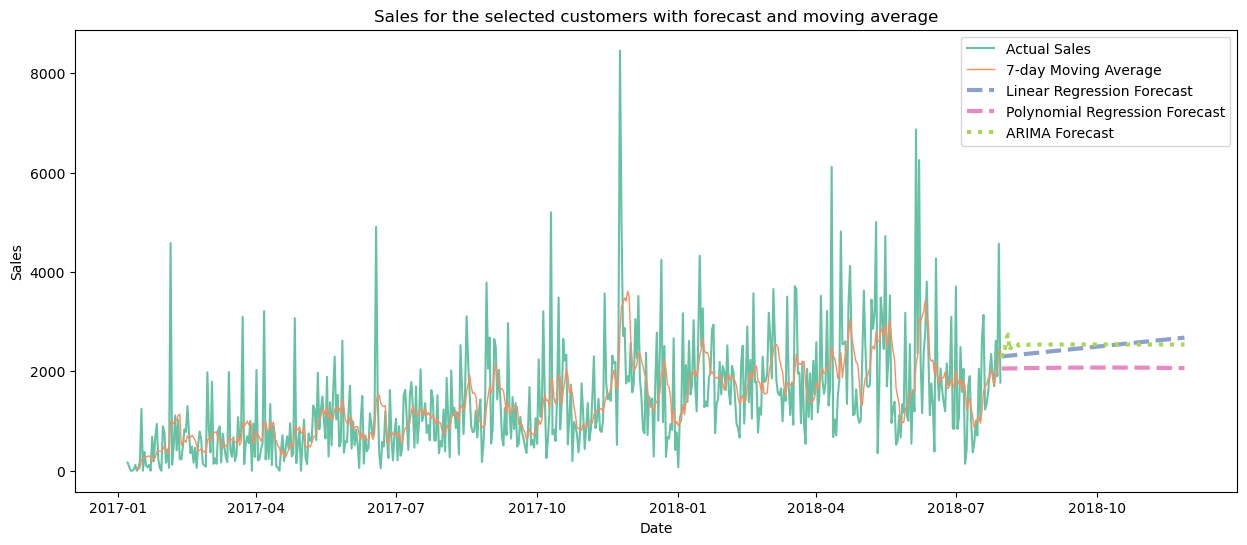

In [59]:
plot_sales_with_forecast_and_moving_average(
    df,
    "Sales for the selected customers with forecast and moving average",
    120
)